In [1]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
import importlib
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
import time
import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

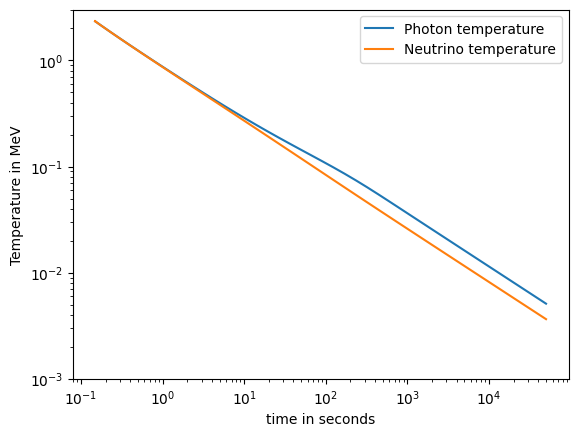

In [2]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV


def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

T_ini=27/TMeV2T9            #initial temperature in MeV

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV
t_cut=1*timeunit            #time at which full reaction network is added

z_ini=e_mass/T_ini

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h



rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini#+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a))#+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)#+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


In [3]:
#import networks
import bbn_test_integrate as bbn_n
nNucs=bbn_n.nnuc
import full_size_net as bbn_full
fnNucs=bbn_full.nnuc
#importlib.reload(bbn_n)
#importlib.reload(bbn_full)
#import He4_test_integrate as He4_n


In [4]:
#compile rhs and Jacobians
prev_time=time.time()
bbn_n.rhs(1000, np.ones(nNucs),0.00001, 1e7)
print(f'rhs compiled in {time.time()-prev_time:.2f} seconds')
prev_time=time.time()
bbn_n.jacobian(1000, np.ones(nNucs),0.00001, 1e7)
print(f'jacobian compiled in {time.time()-prev_time:.2f} seconds')
prev_time=time.time()
bbn_full.rhs(1000, np.ones(fnNucs),0.00001, 1e7)
print(f'Full rhs compile in {time.time()-prev_time:.2f} seconds')
prev_time=time.time()
bbn_full.jacobian(1000, np.ones(fnNucs),0.00001, 1e7)
print(f'Full jacobian compiled in {time.time()-prev_time:.2f} seconds')


rhs compiled in 13.93 seconds
jacobian compiled in 13.47 seconds
Full rhs compile in 44.55 seconds
Full jacobian compiled in 48.83 seconds


In [5]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8.])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]
print()

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))


['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [6]:
#Initial conditions for Y
#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u
m_Li6 = 6.0151228874  *M_u
m_Li7 = 7.016003434   *M_u

m_Be7 = 7.01692871    *M_u



Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]
Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]

spin=PNAsort(Alterspin)
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
A=np.array(PNAsort(Alter_A))


m_Nucs = np.array(PNAsort(Alter_mass))

def rho_bY_cgs(y):
    return sum(m_Nucs[:len(y[n_bparams:])]*y[n_bparams:])*eta_ini*n_gamma_ini/y[1]**3*gcm3

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions

Y_ini=np.zeros(nNucs)+1e-80
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)


Y_ini[6] = 1e-55
Y_ini[7] = 1e-66
Y_ini[8] = 1e-77
Y_ini[9] = 1e-66

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,rho_bY_cgs([T_ini,1]+list(Y)), T_ini*TMeV2T9*1e9)


In [7]:
#Initial conditions from thermal equilibrium

def get_Y_ini(Xn_ini):
    Y_ini2 = np.zeros(nNucs)+1e-50
    #Y_ini=np.array([1e-20 for i in range(nNucs)])


    #Xn_ini = 1/(np.exp(Q/T_ini)+1)
    

    B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(nNucs)]
    g = 1+2*np.array(spin)
        
    for iter1 in range(30):
        Xp_ini = np.exp(Q/T_ini)*Xn_ini
        Y_ini2[0] = Xn_ini        #Set initial neutron mass fraction
        Y_ini2[1] = Xp_ini
        #Set initial proton mass fraction
        X_sum = Y_ini2[0] + Y_ini2[1]
        for i in range(2,nNucs):
            tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            #print(f'A({key}) = {A} : {g[key]*tmp}')
            Y_ini2[i] = g[i]*tmp*(T_ini/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Xp_ini**Z[i]*Xn_ini**(A[i] - Z[i])*np.exp(B[i]/T_ini)/A[i]
            X_sum += Y_ini2[i]*A[i]
        #print(X_sum)
        Xn_ini += (1 - X_sum)/nNucs
        
    return Y_ini2
Xn_ini = 1/(np.exp(Q/T_ini)+1)
Y_ini2 = get_Y_ini(Xn_ini)

    #B12 = 92.2 

#Initial condition based on thermal equilibrium amongst in the most important reactions
B2 = 2.22452
B3 = 7.72
B4 = 28.295673


print(f'From initial guess:')
print('\t'.join([f'{yy:.2e}' for yy in Y_ini]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_ini(Y_ini)]))
print(f'From equilibrium conditions:')
print('\t'.join([f'{yy:.2e}' for yy in Y_ini2]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_ini(Y_ini2)]))


From initial guess:
3.65e-01	6.35e-01	1.01e-12	2.62e-24	3.29e-24	9.47e-29	1.00e-55	1.00e-66	1.00e-77	1.00e-66
-3.98e+03	-3.98e+03	3.98e+03	1.95e-10	2.00e-10	-1.37e-16	5.69e-37	3.64e-45	-1.23e-60	1.80e-46
From equilibrium conditions:
3.65e-01	6.35e-01	1.01e-12	2.63e-24	3.30e-24	2.53e-33	2.48e-57	1.35e-68	7.13e-81	1.16e-68
-3.79e+03	-3.79e+03	3.79e+03	1.75e-10	1.89e-10	7.73e-23	6.25e-43	2.04e-51	1.96e-65	1.01e-52


In [8]:
#initial conditions from Jacobian
AdYdt_ini=lambda Y : Altersort(bbn_n.rhs(t_ini/timeunit, PNAsort(Y) ,rho_bY_cgs([T_ini,1]+list(PNAsort(Y))), T_ini*TMeV2T9*1e9))
AdYdt_jac=lambda Y : bbn_n.jacobian(t_ini/timeunit, PNAsort(Y) ,rho_bY_cgs([T_ini,1]+list(PNAsort(Y))), T_ini*TMeV2T9*1e9)[:, Altersort(range(nNucs))][Altersort(range(nNucs))]
import scipy.linalg as la
aY_ini=Altersort(Y_ini2)
def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x
Yj = np.array([YY for YY in aY_ini])
cut_start = 0
for cut in range(cut_start, len(Yj) - 2, 1):
    for j in range(10):
        print(cut, j)
        print(Yj)
        fyj = -AdYdt_ini(Yj)
        jac = AdYdt_jac(Yj)
        if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
            print('Yj:', Yj)
            raise ValueError
        if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
            print('Yj:', Yj)
            print('fyj:', fyj)
            raise ValueError
        # Implement cut:
        fyj = fyj[cut:]
        jac = jac[cut:, cut:]
        
        # Solution using SVD
        U, s, Vh = la.svd(jac)    
        x = solve_using_svd(U, s, Vh, fyj)
        for k in range(1):
            #A · δx = A · (x + δx) − b
            residuals = jac @ x - fyj
            dx = solve_using_svd(U, s, Vh, residuals)
            x -= dx
        Yj[cut:] += x


def print_stuff(YY, name=''):
    print(f'From {name}:')
    print('\t'.join([f'{yy:.2e}' for yy in YY]))
    print('\t'.join([f'{yy:.2e}' for yy in AdYdt_ini(YY)]))
print_stuff(Yj, 'manual tuning')
print_stuff(aY_ini, 'equilibrium conditions')


0 0
[3.64536614e-01 6.35463386e-01 1.01052083e-12 2.62511434e-24
 3.29559227e-24 2.53459326e-33 2.47807850e-57 1.35308564e-68
 1.16353192e-68 7.13247160e-81]
0 1
[ 3.64459126e-01  6.35463386e-01  1.03181355e-12  2.73586326e-24
  3.43530176e-24 -1.18047041e-24 -6.50959184e-31 -1.98273383e-31
 -3.11574793e-31 -4.94695880e-30]
0 2
[ 3.64459126e-01  6.35463386e-01  1.03173355e-12  2.73775636e-24
  3.43585467e-24  8.07954004e-25  4.93977195e-31 -4.23067050e-31
  5.92064891e-32  4.92879160e-30]
0 3
[3.64459126e-01 6.35463386e-01 1.03173355e-12 2.73784611e-24
 3.43765416e-24 4.17828289e-24 8.60921634e-31 5.56305514e-31
 3.78500315e-31 7.11068649e-30]
0 4
[3.64459126e-01 6.35463386e-01 1.03173355e-12 2.73813500e-24
 3.43703897e-24 3.09125468e-24 3.74930265e-31 5.80449096e-31
 2.19570532e-31 5.76254930e-30]
0 5
[ 3.64459126e-01  6.35463386e-01  1.03173355e-12  2.73744090e-24
  3.43657488e-24  2.16097946e-24  3.66787851e-31  4.40513207e-31
 -5.82233204e-32  2.58946762e-30]
0 6
[3.64459126e-01 6.

In [9]:
#Combining background and network


initial_param=[T_ini,1]+list(PNAsort(Yj))

n_params=nNucs+n_bparams

def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]


#testdata=[]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
    result=ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)
    #testdata.append([t]+result)                 
    return result


In [10]:
#solving with analytic jacobian




def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

def jacfun(t,x):
    return np.array([ndall(t,row)  for row in x.T]).T

Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    #print(np.shape(y))
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    
    
    

jacsolY = integrate.solve_ivp(ndall, [0,t_cut-t_ini], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian)#,t_eval=t_space)

print(jacsolY.message)
print(jacsolY.nfev)
print(jacsolY.njev)
print(jacsolY.nlu)

abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ', sum(np.array(abun)*A[:nNucs]))

The solver successfully reached the end of the integration interval.
2473
106
428
[0.24093166614554232, 0.7589908458970905, 1.8121001545308188e-12, 9.715508954765386e-23, 1.2697866373714437e-22, 5.479512697829102e-26]
sum:  0.9999225120444449


In [11]:
#cut conditions from thermal equilibrium
bbn_full.nnuc
abun
T_cut=jacsolY.y[0][-1]

dYdt_cut=lambda Y : bbn_full.rhs(t_cut/timeunit, Y ,rho_bY_cgs([param[-1] for param in jacsolY.y]), T_cut*TMeV2T9*1e9)

Y_cut=np.zeros(fnNucs)+1e-80
Y_cut[:nNucs] = abun

def get_Y_cut(abun_cut):
    Y_ini3 = np.zeros(fnNucs)+1e-80
    #Y_ini=np.array([1e-20 for i in range(nNucs)])


    #Xn_ini = 1/(np.exp(Q/T_ini)+1)
    

    B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
    g = 1+2*np.array(spin)
        
    for iter1 in range(30):
        
        Xn_cut = abun_cut[0]
        Xp_cut = abun_cut[1]
        Y_ini3[:nNucs] = abun_cut       #Set initial neutron mass fraction
        
        #Set initial proton mass fraction
        #X_sum = Y_ini3[0] + Y_ini3[1]
        for i in range(nNucs,fnNucs):
            tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            #print(f'A({key}) = {A} : {g[key]*tmp}')
            Y_ini3[i] = g[i]*tmp*(T_ini/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Xp_cut**Z[i]*Xn_cut**(A[i] - Z[i])*np.exp(B[i]/T_cut)/A[i]
            #X_sum += Y_ini3[i]*A[i]
        #print(X_sum)
        #Xn_ini += (1 - X_sum)/nNucs
        
    return Y_ini3

Y_cut2 = get_Y_cut(abun)

    #B12 = 92.2 

#Initial condition based on thermal equilibrium amongst in the most important reactions
B2 = 2.22452
B3 = 7.72
B4 = 28.295673


print(f'From initial guess:')
print('\t'.join([f'{yy:.2e}' for yy in Y_cut]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_cut(Y_cut)]))
print(f'From equilibrium conditions:')
print('\t'.join([f'{yy:.2e}' for yy in Y_cut2]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_cut(Y_cut2)]))


From initial guess:
2.41e-01	7.59e-01	9.06e-13	3.24e-23	4.23e-23	1.37e-26	7.95e-51	1.22e-60	4.20e-73	5.79e-61	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80	1.00e-80
-5.67e-02	5.67e-02	-1.49e-11	3.13e-24	-1.77e-23	1.87e-25	2.66e-48	3.80e-56	8.24e-69	9.08e-57	1.14e-63	2.10e-59	-6.18e-68	3.07e-67	-3.13e-67	2.78e-63	1.42e-66	-4.82e-67	-1.40e-68	-2.78e-63	1.11e-63	-5.29e-68	-2.81e-70	-1.11e-63	-1.29e-69	-1.13e-69
From equilibrium conditions:
2.41e-01	7.59e-01	9.06e-13	3.24e-23	4.23e-23	1.37e-26	7.95e-51	1.22e-60	4.20e-73	5.79e-61	1.03e-72	2.19e-69	1.24e-81	4.14e-89	1.63e-100	5.41e-90	3.35e-94	2.13e-104	1.39e-113	2.77e-102	2.12e-105	6.38e-113	1.17e-120	7.31e-116	6.29e-122	2.23e-127
-5.67e-02	5.67e-02	-1.49e-11	3.13e-24	-1.77e-23	1.87e-25	2.66e-48	3.80e-56	7.45e-69	6.61e-55	-1.54e-58	-6.51e-55	-6.61e-69	-1.77e-77	-3.93e-87	-6.16e-78	-5.04e-85	-8.69e-91	-1.55e-101	-5.95e-85	-1.46e-91	-2.67e-100	-5.88e-110	

In [12]:
#cut conditions from Jacobian
AdYdt_cut=lambda Y : Altersort(bbn_full.rhs(t_cut/timeunit, PNAsort(Y) ,rho_bY_cgs([param[-1] for param in jacsolY.y]), T_cut*TMeV2T9*1e9))
AdYdt_jac_cut=lambda Y : bbn_full.jacobian(t_cut/timeunit, PNAsort(Y) ,rho_bY_cgs([param[-1] for param in jacsolY.y]), T_cut*TMeV2T9*1e9)[:, Altersort(range(fnNucs))][Altersort(range(fnNucs))]
import scipy.linalg as la
aY_cut=Altersort(Y_cut2)
def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x
Yj = np.array([YY for YY in aY_cut])
cut_start = nNucs
for cut in range(cut_start, len(Yj) - 2, 1):
    for j in range(10):
        print(cut, j)
        print(Yj)
        fyj = -AdYdt_cut(Yj)
        jac = AdYdt_jac_cut(Yj)
        if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
            print('Yj:', Yj)
            raise ValueError
        if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
            print('Yj:', Yj)
            print('fyj:', fyj)
            raise ValueError
        # Implement cut:
        fyj = fyj[cut:]
        jac = jac[cut:, cut:]
        
        # Solution using SVD
        U, s, Vh = la.svd(jac)    
        x = solve_using_svd(U, s, Vh, fyj)
        for k in range(1):
            #A · δx = A · (x + δx) − b
            residuals = jac @ x - fyj
            dx = solve_using_svd(U, s, Vh, residuals)
            x -= dx
        Yj[cut:] += x


def print_stuff(YY, name=''):
    print(f'From {name}:')
    print('\t'.join([f'{yy:.2e}' for yy in YY]))
    print('\t'.join([f'{yy:.2e}' for yy in AdYdt_cut(YY)]))
print_stuff(Yj, 'manual tuning')
print_stuff(aY_cut, 'equilibrium conditions')


10 0
[2.40931666e-001 7.58990846e-001 9.06050077e-013 3.23850298e-023
 4.23262212e-023 1.36987817e-026 7.94975073e-051 1.22049408e-060
 5.78751858e-061 4.20376501e-073 2.19443700e-069 1.02917307e-072
 1.23946015e-081 4.13628786e-089 5.40558334e-090 1.62866352e-100
 3.34728188e-094 2.76882514e-102 2.13360264e-104 2.12053337e-105
 1.38757159e-113 6.38059048e-113 7.31396529e-116 1.16867848e-120
 6.28563774e-122 2.22800218e-127]
10 1
[ 2.40931666e-001  7.58990846e-001  9.06050077e-013  3.23850298e-023
  4.23262212e-023  1.36987817e-026  7.94975073e-051  1.22049408e-060
  5.78751858e-061  4.20376501e-073  7.08820537e-074  7.60164471e-078
  2.09120716e-087  2.72616504e-095  2.95435755e-095  2.82741496e-097
 -3.70766526e-093  1.17067564e-100 -1.12416360e-097 -7.22225137e-098
  7.49399683e-097  5.63121313e-097 -3.36673410e-101  1.82877983e-099
  7.31511930e-099 -1.73734083e-098]
10 2
[ 2.40931666e-001  7.58990846e-001  9.06050077e-013  3.23850298e-023
  4.23262212e-023  1.36987817e-026  7.9497

In [13]:
print(Yj-aY_cut)
print(Y_cut2-Y_cut)

[ 0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000  0.00000000e+000  0.00000000e+000
  0.00000000e+000  0.00000000e+000 -2.19436612e-069 -1.02916547e-072
 -1.23945806e-081 -4.13628627e-089 -5.40558126e-090 -1.62866338e-100
 -3.34728159e-094 -2.76882489e-102 -2.13360260e-104 -2.12053332e-105
 -1.38757158e-113 -6.38059045e-113 -7.31396526e-116 -1.16867848e-120
 -6.28563774e-122 -2.22800218e-127]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.02917306e-72  2.19443700e-69
 -8.76053985e-81 -9.99999996e-81 -1.00000000e-80 -9.99999999e-81
 -1.00000000e-80 -1.00000000e-80 -1.00000000e-80 -1.00000000e-80
 -1.00000000e-80 -1.00000000e-80 -1.00000000e-80 -1.00000000e-80
 -1.00000000e-80 -1.00000000e-80]


In [14]:
#Combining background and full network

cut_param=[param[-1] for param in jacsolY.y[:n_bparams]]+list(PNAsort(Yj))

t_range_cut=[0,1e5*timeunit-t_cut+t_ini]

full_n_params=bbn_full.nnuc+n_bparams


def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]


#testdata=[]

def ndfull(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
    result=ndbackground(t,y[:n_bparams])+list( bbn_full.rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)
    #testdata.append([t]+result)                 
    return result


In [15]:
#solving with full network




def full_jac(t,y):
    return bbn_full.jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit


Factor=None
def full_jacobian(t,y):
    #print(np.shape(y))
    jac=np.append(np.zeros((fnNucs,n_bparams)),full_jac(t,y),axis=1)
    return np.append(np.zeros((n_bparams,full_n_params)),jac,axis=0)
    
    
    

fullsolY = integrate.solve_ivp(ndfull, t_range_cut, cut_param,method='Radau',atol=1e-80,rtol=1e-6,jac=full_jacobian)#,t_eval=t_space)

print(fullsolY.message)
print(fullsolY.nfev)
print(fullsolY.njev)
print(fullsolY.nlu)

final_abun=[fabun[-1] for fabun in fullsolY.y[n_bparams:]]


print([final_abun[0],final_abun[1],2*final_abun[2],3*final_abun[3],3*final_abun[4],4*final_abun[5]])
print('sum: ', sum(np.array(final_abun)*A))

The solver successfully reached the end of the integration interval.
22425
1493
3272
[8.164588270765925e-12, 0.7526049009521532, 3.781830409801516e-05, 1.8349451424961492e-07, 2.3221135191592018e-05, 0.2472563856393504]
sum:  0.999922512044456


In [16]:
#Combine the high temperature and and full network solutions
solY=np.concatenate((np.concatenate((jacsolY.y,np.multiply(np.ones((len(jacsolY.y[0]),fnNucs-nNucs)),cut_param[n_params:]).T)),fullsolY.y),axis=1)

soltime=np.concatenate((jacsolY.t+t_ini,fullsolY.t+t_cut))/timeunit

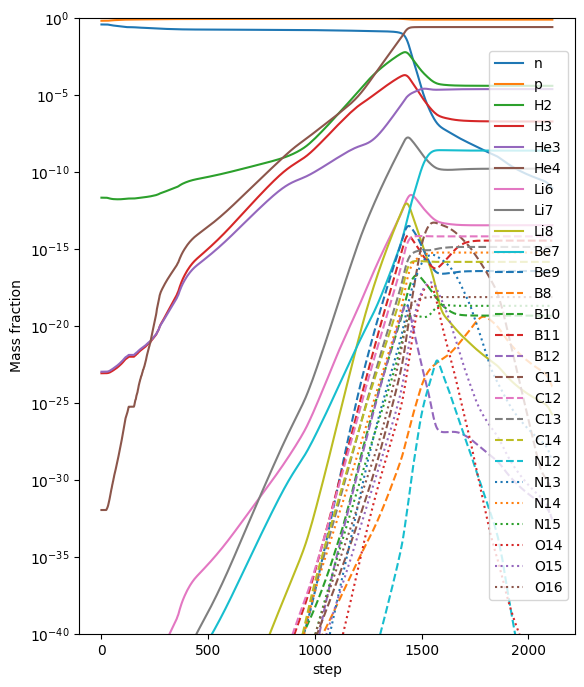

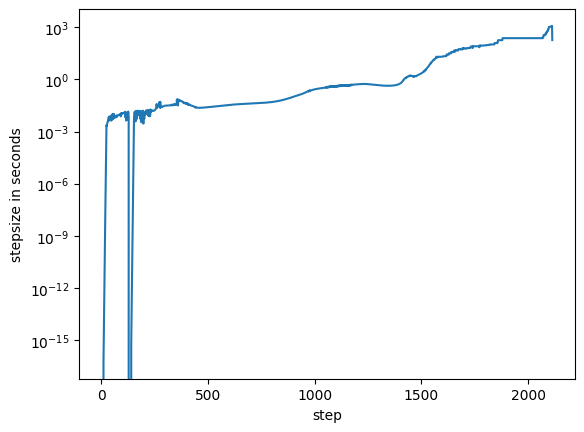

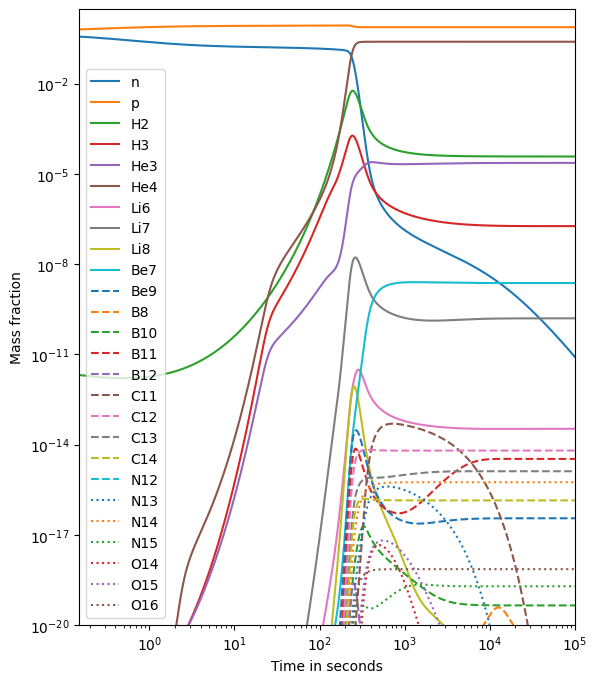

In [17]:
# Plot the results    

plt.figure('abundance',figsize=(6.4, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3
line=['-']*10+['--']*10+[':']*10

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-40,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1]) for i in range(len(soltime))] )
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')


plt.figure('abundance',figsize=(6.4, 8))
for i in range(fnNucs):
    plt.plot(soltime, A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('Time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-20,3)
plt.xlim(t_ini/timeunit,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
#find alterbbn abundance
result = subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/alter_eta.x", str(eta)], capture_output=True)

In [19]:
#compare to Alterbbn abundance
abun=final_abun
print('Observational values')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H ')
print('value:\t 2.450e-01 \t 2.569e-05 \t 1.1e-05 \t 1.6e-10')
print(' +/-  \t 0.030e-01  \t 0.027e-05 \t 0.2e-05 \t 0.3e-10')

print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*final_abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


print(' ')
print('Results from Alterbbn, with theoretical uncertainties:')
for info in result.stdout.decode("utf-8").split('\n')[8:11]:
    print(info)
    #print('lmao')

alterbbn_abun=np.array([float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i]) for i in range(1,7)])

reorderabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]

ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i+1])/reorderabun[i])
print(' ')
print('ratio of this code to ALterbbn results:')
print(ratio_Str)

Observational values
	 Yp  		 H2/H 		 H3/H 		 Li7/H 
value:	 2.450e-01 	 2.569e-05 	 1.1e-05 	 1.6e-10
 +/-  	 0.030e-01  	 0.027e-05 	 0.2e-05 	 0.3e-10
 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.512e-05	 1.037e-05	 4.766e-10	 7.454e-15	 4.467e-10
 
Results from Alterbbn, with theoretical uncertainties:
	 Yp		 H2/H		 He3/H		 Li7/H		 Li6/H		 Be7/H
value:	 2.473e-01	 2.435e-05	 1.031e-05	 5.466e-10	 1.073e-14	 5.180e-10
 +/- :	 3.209e-04	 9.779e-07	 1.776e-07	 4.427e-11	 1.073e-14	 4.371e-11
 
ratio of this code to ALterbbn results:
ratio:	 1.00018	 0.969157	 0.994593	 1.14683	 1.43954	 1.15973


In [20]:
#Load precise Alterbbn data
data=np.loadtxt('./Alterdata/output.txt',skiprows=2)

'''
#run Alterbbn with chosen integration routine
failsafe=12
subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/no_err_calc.x", str(failsafe)], capture_output=True)
data=np.loadtxt('./output.txt',skiprows=2)
'''


#remove non-time steps
prevtime=0
mask=[]
for time in data:
    if time[0]>prevtime:
        prevtime=time[0]
        mask.append(True)
    else:
        mask.append(False)


data=data[mask,...]

print(data[0,0]/1e3)
#151983983107661.34
#1.519839831076613438e+14
#2.264733810941325e+20

#change Alterbbn data for time and temperature in hbar/GeV to hbar/MeV
data[:,0]*=1e-3
data[:,1]*=1e3
data[:,2]*=1e3
#change order of isotopes to be sorted by Y rather than A
data[:,3:]=PNAsort(data[:,3:].T).T
print(t_ini)

2.2641798198795177e+20
2.264733810941325e+20


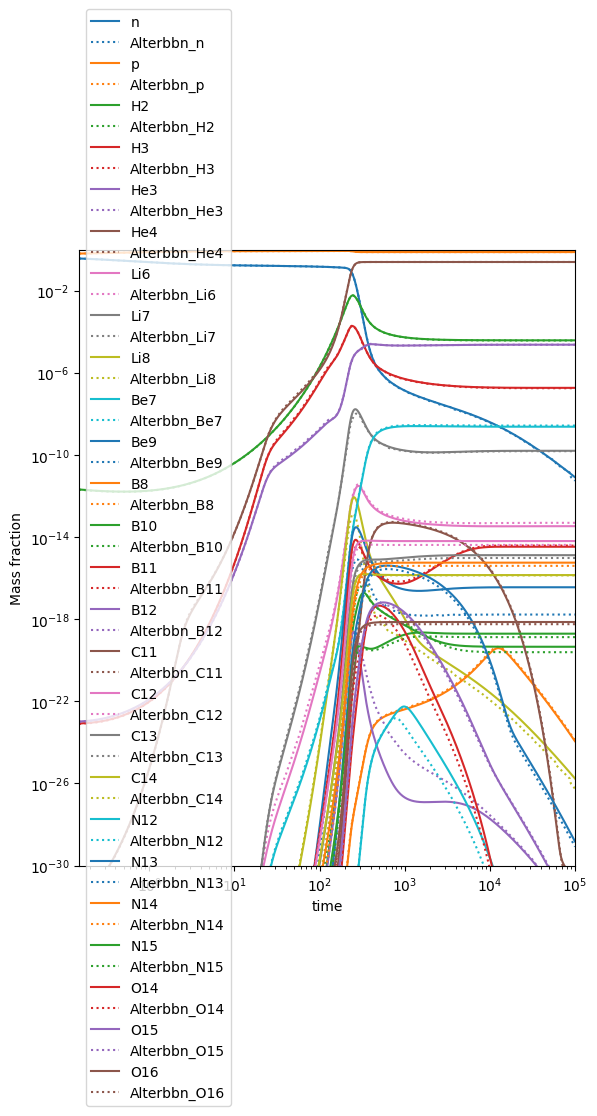

In [32]:
# Plot the results
  
plt.figure('abundance',figsize=(6.4, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3

for i in range(fnNucs):
    plt.plot(soltime, A[i]*solY[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(data[:,0]/timeunit, A[i]*data[:,i+3],':', color=colors[i], label='Alterbbn_'+Y_labels[i])


plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.ylim(1e-30,1)
plt.xlim(t_ini/timeunit ,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left')
plt.show()

In [22]:

t_space=data[:,0]-data[0,0]
SolAltertime = integrate.solve_ivp(ndall, [t_space[0],t_space[-1]], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian,t_eval=t_space)
fullsolY = integrate.solve_ivp(ndfull, t_range_cut, cut_param,method='Radau',atol=1e-80,rtol=1e-6,jac=full_jacobian)#,t_eval=t_space)
jacsolY = integrate.solve_ivp(ndall, [0,t_cut-t_ini], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian)#,t_eval=t_space)


In [23]:
t_space=[point for point in data[:,0] if point<t_cut]-data[0,0]

alterjacsolY = integrate.solve_ivp(ndall, [0,t_cut-t_ini], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian,t_eval=t_space)

ft_space=[point for point in data[:,0] if point>t_cut]
ft_space-=ft_space[0]
alterfullsolY = integrate.solve_ivp(ndfull, [0,ft_space[-1]], cut_param,method='Radau',atol=1e-80,rtol=1e-6,jac=full_jacobian,t_eval=ft_space)


In [24]:
#Combine the high temperature and and full network solutions
altersolY=np.concatenate((np.concatenate((alterjacsolY.y,np.multiply(np.ones((len(alterjacsolY.y[0]),fnNucs-nNucs)),cut_param[n_params:]).T)),alterfullsolY.y),axis=1)

altersoltime=np.concatenate((alterjacsolY.t+t_ini,alterfullsolY.t+t_cut))/timeunit

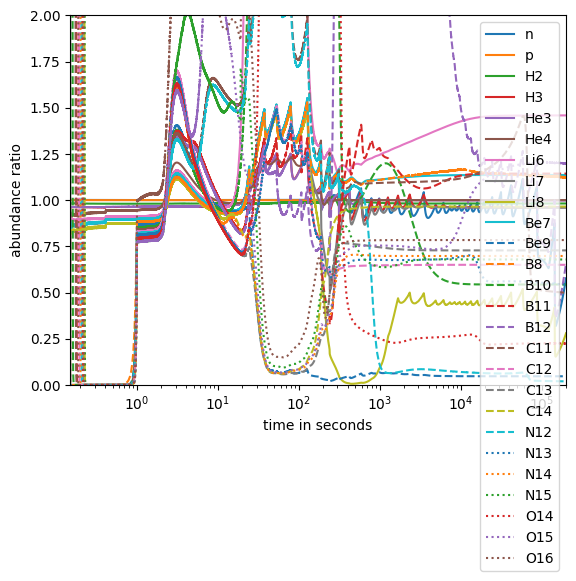

In [25]:
# Plot the results
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3
line=['-']*10+['--']*10+[':']*10

for i in range(fnNucs):
    plt.plot(data[:,0]/timeunit, data[:,i+3]/altersolY[n_bparams+i],line[i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('abundance ratio')

plt.xscale('log')


plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(0,2)

plt.legend(loc='upper right')
plt.show()

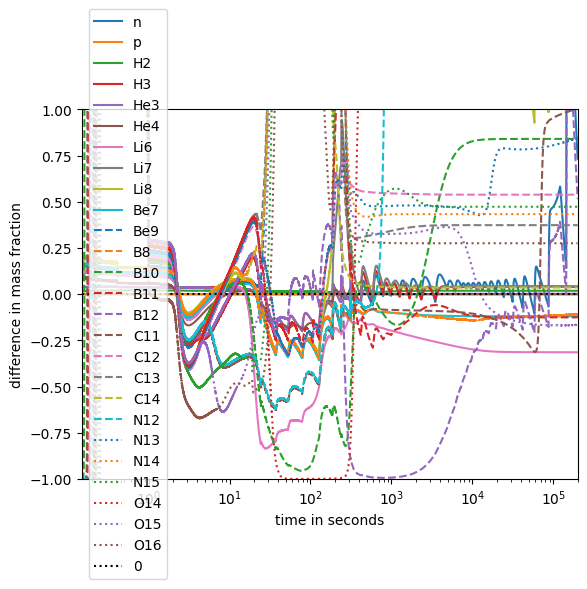

In [26]:
#plt.plot(data[:,0]/timeunit, (SolAltertime.y[n_bparams+i]-data[:,i+3])/data[:,i+3], label=' (Y - Y_alterbbn)/Y_alterbbn')
#plt.plot(data[:,0]/timeunit, (data[:,0]/timeunit/1e2)**-10*A[5]*data[:,5+3],':', label='Alterbbn_Helium4')
#plt.axhline(0,color='r',linestyle='--',label='0')

for i in range(fnNucs):
    plt.plot(data[:,0]/timeunit, (altersolY[n_bparams+i]-data[:,i+3])/data[:,i+3],line[i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('difference in mass fraction')

plt.xscale('log')
plt.axhline(0,color='k',linestyle=':',label='0')

plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(-1,1)

plt.legend(loc='center left')
plt.show()

In [27]:
#compare to Alterbbn abundance
abun=[aabun[-1] for aabun in altersolY[n_bparams:]]

print('Observational values')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H ')
print('value:\t 2.450e-01 \t 2.569e-05 \t 1.1e-05 \t 1.6e-10')
print(' +/-  \t 0.030e-01  \t 0.027e-05 \t 0.2e-05 \t 0.3e-10')

print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


print(' ')
print('Results from Alterbbn, with theoretical uncertainties:')
for info in result.stdout.decode("utf-8").split('\n')[8:11]:
    print(info)
    #print('lmao')

alterbbn_abun=np.array([float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i]) for i in range(1,7)])

reorderabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]
abun=data[-1,3:]
Alterabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]


ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i+1])/reorderabun[i])
print(' ')
print('Ratio of this code to ALterbbn results:')
print(ratio_Str)

print(' ')
print('High precision Alterbbn results')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(Alterabun[i]/reorderabun[i])
print(' ')
print('Ratio of this code to high precision Alterbbn results:')
print(ratio_Str)

Observational values
	 Yp  		 H2/H 		 H3/H 		 Li7/H 
value:	 2.450e-01 	 2.569e-05 	 1.1e-05 	 1.6e-10
 +/-  	 0.030e-01  	 0.027e-05 	 0.2e-05 	 0.3e-10
 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.512e-05	 1.037e-05	 4.766e-10	 7.455e-15	 4.467e-10
 
Results from Alterbbn, with theoretical uncertainties:
	 Yp		 H2/H		 He3/H		 Li7/H		 Li6/H		 Be7/H
value:	 2.473e-01	 2.435e-05	 1.031e-05	 5.466e-10	 1.073e-14	 5.180e-10
 +/- :	 3.209e-04	 9.779e-07	 1.776e-07	 4.427e-11	 1.073e-14	 4.371e-11
 
Ratio of this code to ALterbbn results:
ratio:	 1.00018	 0.969236	 0.994492	 1.14683	 1.43935	 1.15973
 
High precision Alterbbn results
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.474e-01	 2.467e-05	 1.034e-05	 5.363e-10	 1.087e-14	 5.075e-10
 
Ratio of this code to high precision Alterbbn results:
ratio:	 1.00047	 0.981946	 0.997582	 1.12529	 1.45865	 1.13613


In [28]:
[aabun[-1] for aabun in altersolY[n_bparams:]]

[1.122715623009244e-16,
 0.7526049009885849,
 1.8907599052522716e-05,
 6.102313574132072e-08,
 7.741307284350474e-06,
 0.06181409658888034,
 5.610473791551099e-15,
 2.254988310359856e-11,
 4.113794216338799e-34,
 3.3615561608833147e-10,
 3.961037818442233e-18,
 6.799471926115907e-35,
 4.51441674244901e-21,
 3.04512450053488e-16,
 1.5023635253035267e-41,
 2.6044760210404672e-42,
 5.29431063656074e-16,
 1.0036302314119335e-16,
 9.993509679676182e-18,
 6.252496954015811e-75,
 1.079536344032935e-42,
 4.021126043968859e-17,
 1.3043034721652784e-20,
 7.806272541811387e-73,
 1.3569242682142954e-47,
 4.526813815970634e-20]

In [29]:
final_abun[10]/abun[10]

21.325347452982776